# Time Series Analysis

**Contents**

1. Data ETL | Processing
2. Modeling
3. Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.timeseries import TimeSeries

from components import config
from components.ts_logger import logger
from components.utils import get_csv_dataframe

2024-01-18 22:38:18 [info     ] logger initialized


## 1. Data ETL | Processing

- Parse CSV Data
- Missing Values ?
- Stationarity ?

### Parse CSV Data

In [2]:
dataset_path = config.io_paths["DATASET"]
index_column = "DateTime"
datetime_format = config.DATETIME_FORMAT

df = get_csv_dataframe(dataset_path, index_column, datetime_format)
df_load = df[["Consumption"]] #len : 36772
df_load = df_load.resample('H').mean()

logger.info(">> dataset imported")
df_load.info()

2024-01-18 22:38:20 [info     ] >> dataset imported
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36768 entries, 2019-01-01 00:00:00 to 2023-03-12 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  36764 non-null  float64
dtypes: float64(1)
memory usage: 574.5 KB


### Missing Values (?)

- imputation : constant value imputation, mean, median or mode imputation, and forward-fill or backward-fill.
- interpolation : use mathematical functions to estimate missing values based on the values of the surrounding observations, e.g. `linear interpolation, polynomial interpolation, and spline interpolation`
- predictive modeling : build ml models to predict missing values, e.g. knn, regression, dts, random forest.

In [3]:
print("missing values: ", df_load.isnull().sum())
logger.info(">> checking missing values")
logger.info(">> interpolating missing values")
df_load = df_load.interpolate()
print("missing values: ", df_load.isnull().sum())
print("dataset shape: ", df_load.shape)

missing values:  Consumption    4
dtype: int64
2024-01-18 22:38:21 [info     ] >> checking missing values
2024-01-18 22:38:21 [info     ] >> interpolating missing values
missing values:  Consumption    0
dtype: int64
dataset shape:  (36768, 1)


### Stationarity ?



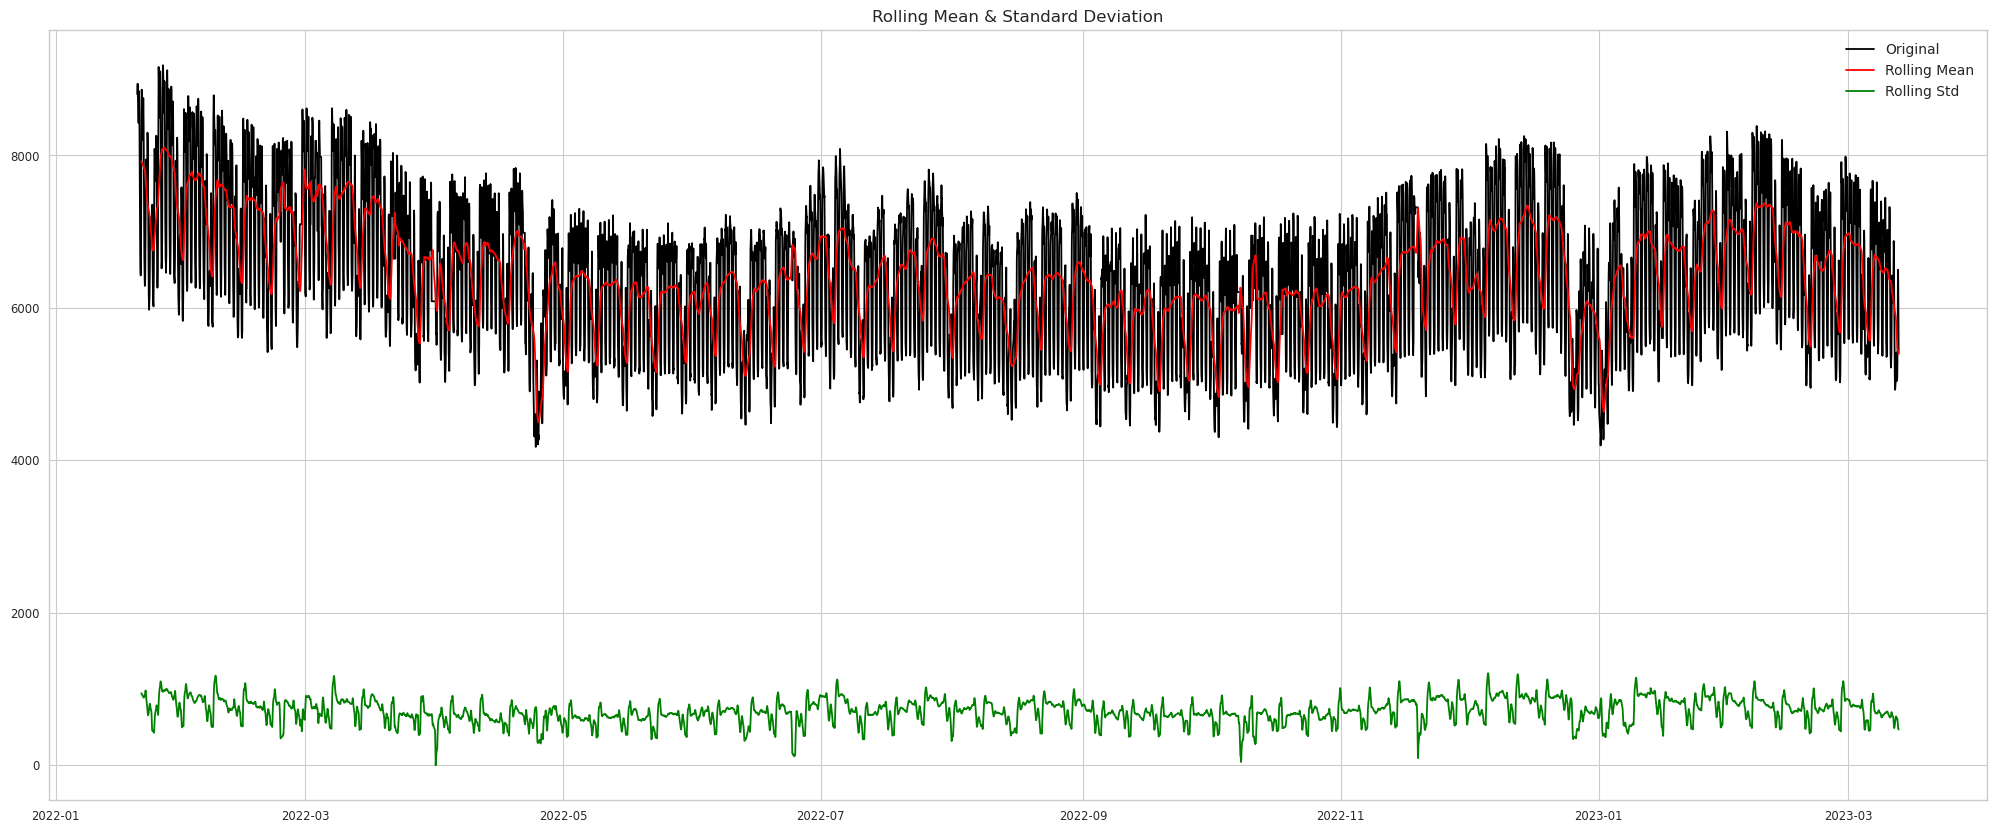

In [10]:
#rolling stats
plt.plot(df_load.iloc[-10000:], label='Original')
plt.plot(df_load.iloc[-10000:].rolling(window=24).mean(), color='red', label='Rolling Mean') #daily rolling avg
plt.plot(df_load.iloc[-10000:].rolling(window=24).std(), color='green', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [11]:
from components.utils import (
    adf_test,
    kpss_test
)

def is_stationary(ts_series: pd.Series) -> bool:
    p_adf = adf_test(ts_series)["p-value"]
    logger.info(">> adf p-value: {}".format(p_adf))
    p_kpss = kpss_test(ts_series)["p-value"]
    logger.info(">> kpss p-value: {}".format(p_kpss))
    return (p_adf < 0.05) and (p_kpss > 0.05)

is_stationary(df_load)

2024-01-18 22:41:17 [info     ] >> adf p-value: 3.425121590696174e-26
2024-01-18 22:41:17 [info     ] >> kpss p-value: 0.01


/home/mnpr/Workspace/Opencampus/TimeSeriesAnalysis/src/components/utils.py:74: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(ts_series, regression="c")


False

## 2. Modeling

- ARIMA
- Seasonal ARIMA
- Darts

In [31]:
df_train, df_test = df_load[:-24*7*4], df_load[-24*7*4:]
logger.info(">> train set: {}, test set: {}".format(len(df_train), len(df_test)))

def get_forecast (df_test, model):
    fitted, confint = arima_model.predict(n_periods=len(df_test), return_conf_int=True)

    fitted_series = pd.Series(fitted, index=df_test.index)
    lower_series = pd.Series(confint[:, 0], index=df_test.index)
    upper_series = pd.Series(confint[:, 1], index=df_test.index)

    plt.plot(df_test)
    plt.plot(fitted, color='red')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Load Consumption Forecast")
    plt.show()

36096 672


### ARIMA

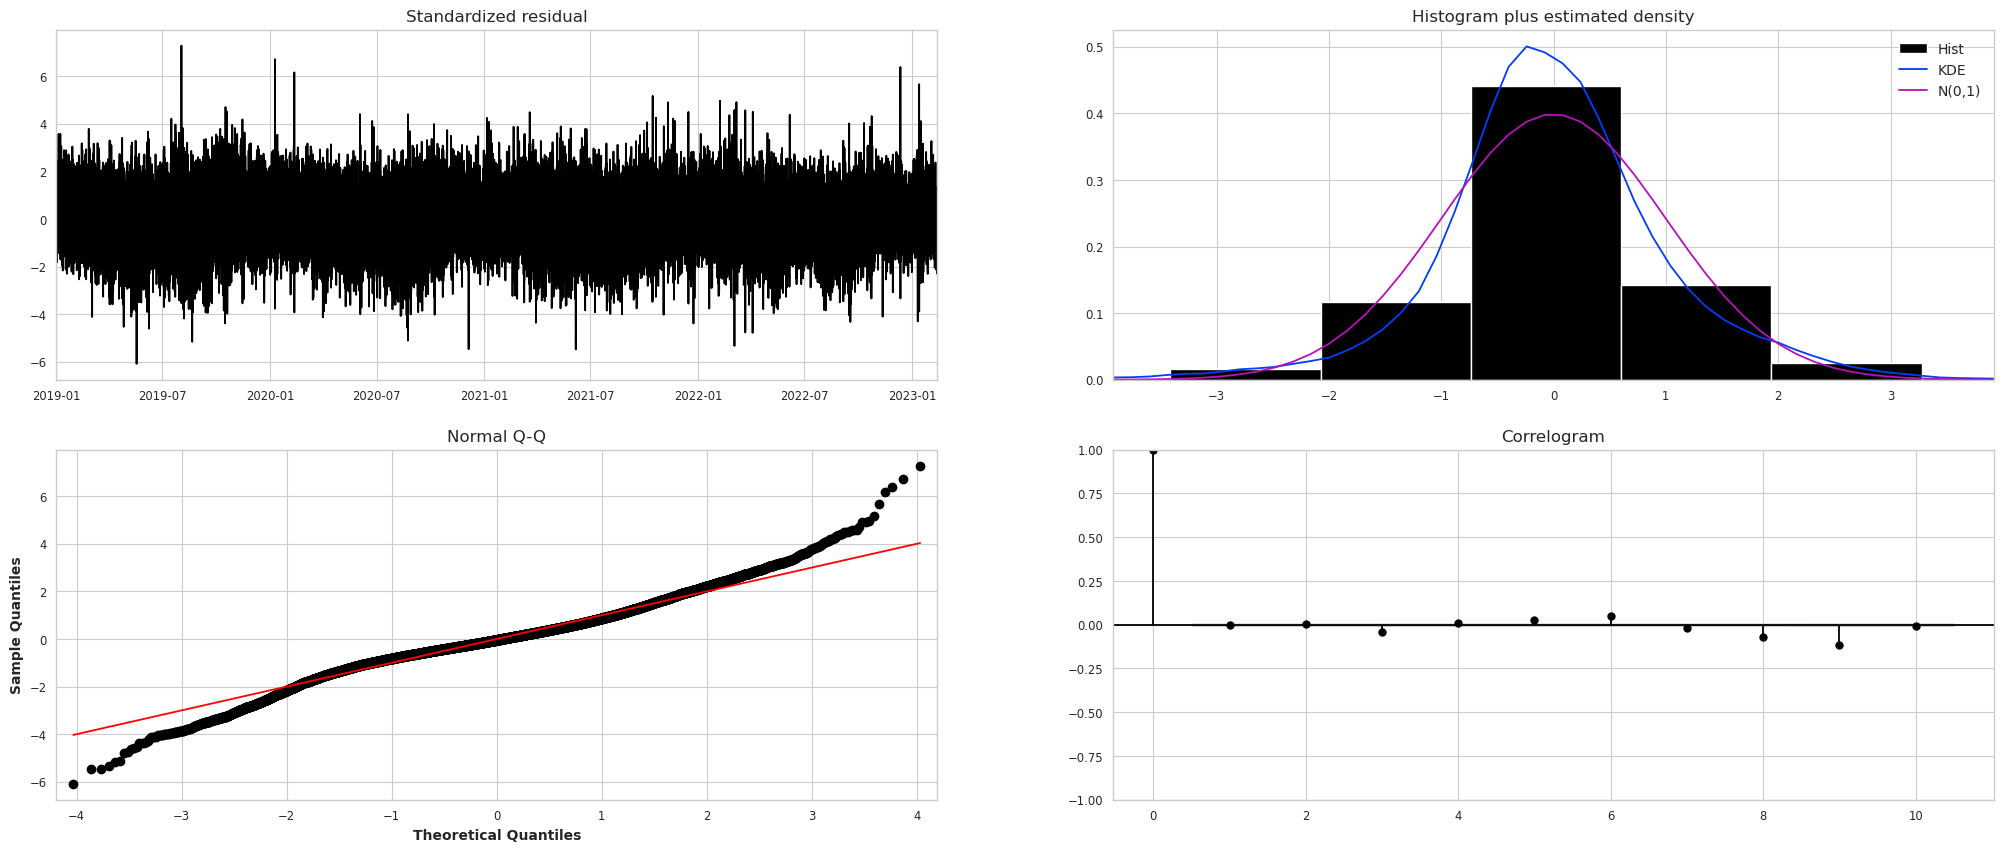

In [36]:
import pmdarima as pma

arima_model = pma.auto_arima(
    df_train
    , start_p=1
    , start_q=1
    , test='adf'
    , max_p=3
    , max_q=3
    , m=1
    , d=None
    , seasonal=False
    , error_action='warn' #shows errors ('ignore' silences these)
    , suppress_warnings=True
    , stepwise=True
)

arima_model.plot_diagnostics()
plt.show()

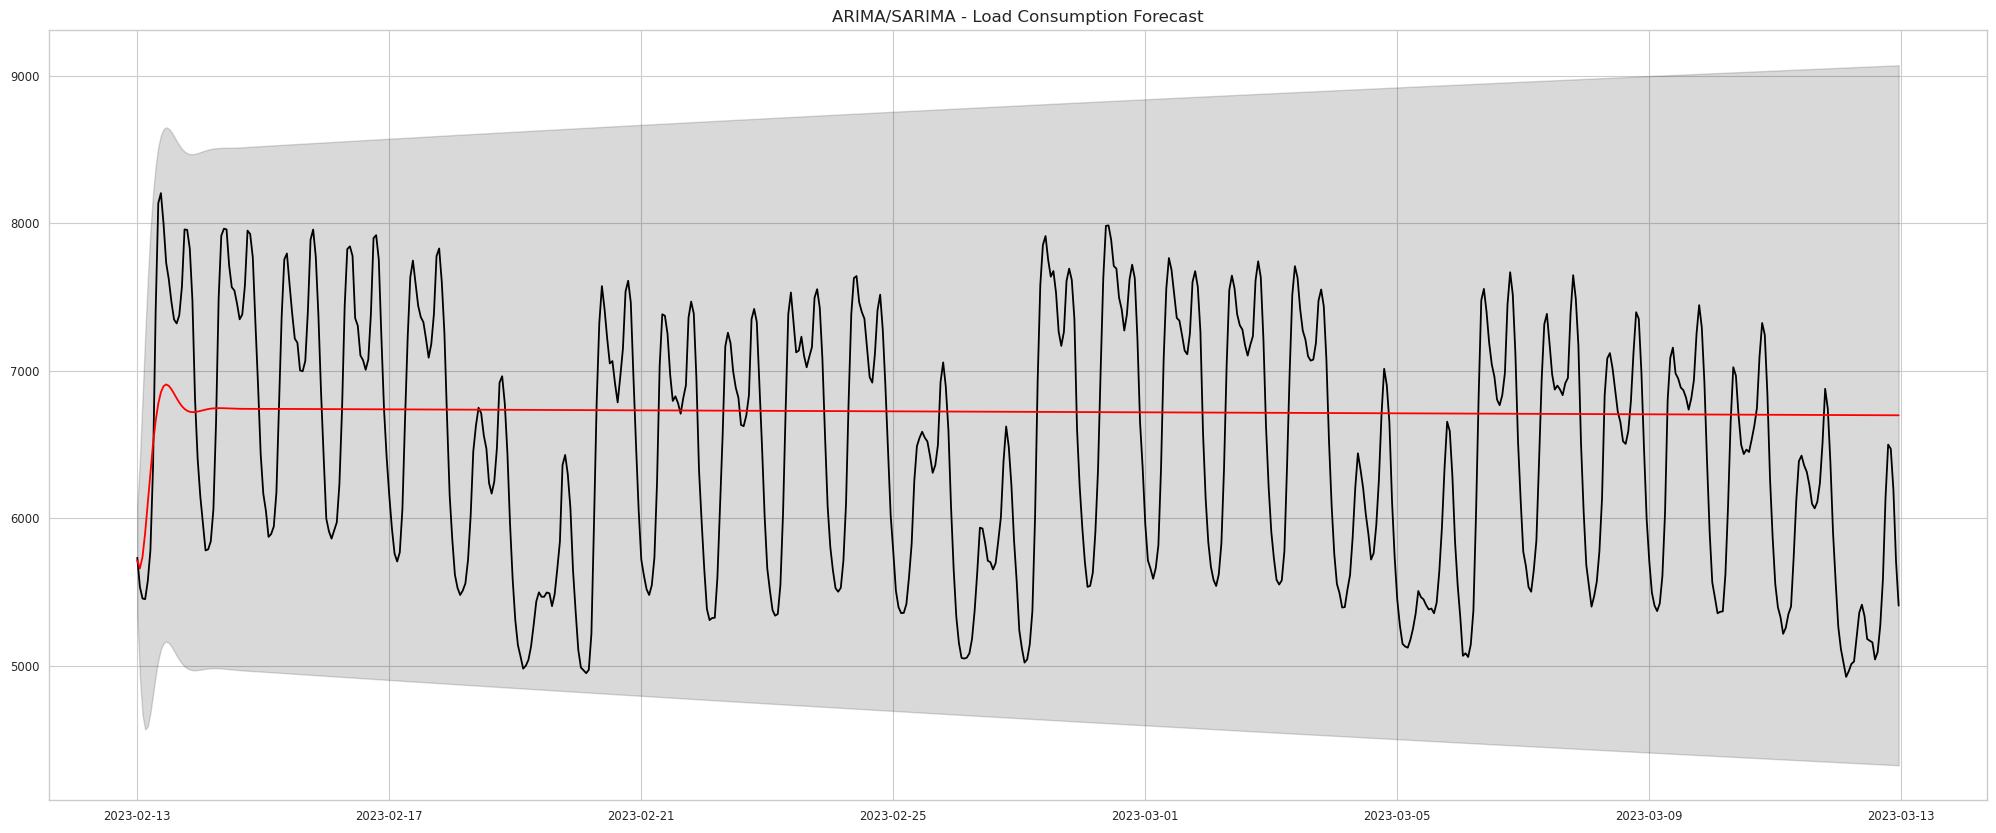

In [38]:
def get_forecast (df_test, model):
    fitted, confint = arima_model.predict(n_periods=len(df_test), return_conf_int=True)

    fitted_series = pd.Series(fitted, index=df_test.index)
    lower_series = pd.Series(confint[:, 0], index=df_test.index)
    upper_series = pd.Series(confint[:, 1], index=df_test.index)

    plt.plot(df_test)
    plt.plot(fitted, color='red')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Load Consumption Forecast")
    plt.show()

get_forecast(df_test, arima_model)

### SARIMA

In [ ]:
import pmdarima as pma

sarima_model = pma.auto_arima(
    df_train
    , start_p=1
    , start_q=1
    , test='adf'
    , max_p=3
    , max_q=3
    , m=24
    , start_P=0
    , seasonal=True
    , d=None
    , D=1
    , trace=False
    , error_action='warn' #shows errors ('ignore' silences these)
    , suppress_warnings=True
    , stepwise=True
)

sarima_model.plot_diagnostics()
plt.show()

In [ ]:
get_forecast(df_test, sarima_model)

### Darts

In [ ]:
from darts.models import (
    NaiveSeasonal
    , ExponentialSmoothing
)
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.metrics import mape

In [ ]:
data_series = TimeSeries.from_dataframe(df_load)

train_set, valid_set = data_series[:-24*7*16], data_series[-24*7*16:] # 16 weeks
logger.info(">> train set: {}, valid set: {}".format(len(train_set), len(valid_set)))

train_set.plot(label='train set')
valid_set.plot(label='validation', color='orange')
plt.show()

### Train Test Split

In [ ]:
load_model = NaiveSeasonal(K=24) #daily seasonality
load_model.fit(train_set)
logger.info(">> fit NaiveSeasonal model")

prediction = load_model.predict(len(valid_set))
logger.info(">> predict with valid set")

valid_set.plot(label='actual')
prediction.plot(label='predict', low_quantile=0.05, high_quantile=0.95)
plt.legend()


logger.info(">> Mean average percentage error: {}".format(mape(valid_set, prediction)))

In [ ]:
#holz winter
load_model = ExponentialSmoothing(
    trend=ModelMode.ADDITIVE,
    seasonal=SeasonalityMode.MULTIPLICATIVE
)
load_model.fit(train_set)
logger.info(">> fit NaiveSeasonal model")

prediction = load_model.predict(len(valid_set))
logger.info(">> predict with valid set")

valid_set.plot(label='actual')
prediction.plot(label='predict', low_quantile=0.05, high_quantile=0.95)
plt.legend()

logger.info(">> Mean average percentage error: {}".format(mape(valid_set, prediction)))

## 3. Evaluation